In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib import animation
import ipywidgets as widgets
from sympy import *


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Numerical Analysis of the Trajectory of an Elastic Pendulum

## 1. Background and Equations

### 1.1 Background
Elastic pendulum is a mass that is attached to a spring instead of a non-stretchable rod or string like a normal pendulum. This is an interesting problem because if one drops the pendulum at an angle, the mass will drop due to gravity, and the length of the cord attached to the mass also lengthens due to gravity and the elasticity of the spring. 

In this analysis, some assumptions are made: 
1. The only force that acts on the mass is gravity.
2. The mass of the spring is negligible.
3. As the mass swings around, there is no air resistance.


### 1.2 Equations
The elastic pendulum is expressed by using Langrange's equation of motion $L \equiv T - V$, in which $L$ is the Lagrange's equation, $T$ is the kinetic energy and $V$ is the potential energy. [1](https://people.duke.edu/~hpgavin/StructuralDynamics/LagrangesEqns.pdf), [2](https://scholar.harvard.edu/files/david-morin/files/cmchap6.pdf)

(Please see the figure [here](https://drive.google.com/file/d/1_t2O8IoqyUGzxaRutDDO39YEzIrXy1mi/view?usp=sharing), also I made that myself.)

Choosing the coordinate of $x$ and $\theta$, with the following parameters:

| Parameter | Meaning | 
| :- | :- |
| $m$ | mass of the object attached to the spring | 
| $v_x$  | velocity of the mass in the $x$-direction | 
| $v_\theta$| velocity of the mass in the $\theta$-direction| 
| $x$ | displacement of the mass in the $x$-direction| 
| $\dot{x}$ | equivalent to $v_x$ | 
| $\ddot{x}$| acceletation of the mass in the $x$-direction|
| $l$ | relaxed length of the spring |
| $\theta$ | angular displacement of the mass-spring system in the $\theta$-direction|
| $\dot{\theta}$ | equivalent to $v_\theta$  |
| $\ddot{\theta}$ | acceletation of the mass in the $\theta$-direction |
| $g$ | gravitaional acceleration constant |
| $k$ | stiffness of the spring |

#### 1.2.1 Kinetic Energy
$$
T = \frac{1}{2} m \vec{v}^2 \\
T = \frac{1}{2}m(v_x^2 + v_\theta^2) \\
T = \frac{m}{2}(\dot{x}^2+ (l\dot{\theta}^2)) \\
T = \frac{m}{2}(\dot{x}^2 + (l+x)^2)\dot{\theta}^2)
$$

#### 1.2.2 Potential Energy
$$
V = mgh + \frac{1}{2}kx^2 \\
V = -mg(l+ x)\cos{\theta} + \frac{1}{2}kx^2
$$

#### 1.2.3 Lagrange's Equations
$$
L = T - V \\
L = \frac{m}{2}(\dot{x}^2 + (l_0+x)^2)\dot{\theta}^2) - \left( -mg(l_0 + x)\cos{\theta} + \frac{1}{2}kx^2 \right) \\
$$

$$
\frac{d}{dt}\left( \frac{\partial L}{\partial \dot{x}}\right) - \frac{\partial L}{\partial x} = 0 \\
m\ddot{x} - (m(l+x)\dot{\theta}^2 + mg\cos{\theta} - kx) = 0 \\
m\ddot{x} - m(l+x)\dot{\theta}^2 + kx - mg\cos{\theta} = 0 \\
\ddot{x} - (l+x)\dot{\theta}^2 + \frac{kx}{m} - g\cos{\theta} = 0 \\
\ddot{x} = (l+x)\dot{\theta}^2 - \frac{kx}{m} + g\cos{\theta}
$$

$$
\frac{d}{dt}\left( \frac{\partial L}{\partial \dot{\theta}}\right) - \frac{\partial L}{\partial \theta} = 0 \\
2m(l+x)\dot{x}\dot{\theta} + m(l+x)^2\ddot{\theta} + mg(l+x)\sin{\theta} = 0 \\
2(l+x)\dot{x}\dot{\theta} + (l+x)^2\ddot{\theta} + g(l+x)\sin{\theta} = 0 \\
\ddot{\theta} = \frac{-2}{l+x}\dot{x}\dot{\theta} - \frac{g}{l+x}\sin{\theta}
$$

#### 1.2.4 System of Equations to be solved

From the above derivation, we have a system of two second order ODEs to solve as follows:


$$
\ddot{\theta} = \frac{-2}{l+x}\dot{x}\dot{\theta} - \frac{g}{l+x}\sin{\theta}\\
\ddot{x} = (l + x) \dot{\theta}^2 - \frac{k}{m}x + g \cos{\theta} \\
$$

To apply the time integrators, we need to convert this system of second order ODEs to a system of first order ODEs as follows, in which $\omega \equiv \dot{\theta} \Rightarrow \ddot{\theta} = \frac{d\omega}{dt}$ and $v \equiv \dot{x} \Rightarrow \ddot{x} \equiv \frac{dv}{dt}$.

$$
\frac{d\omega}{dt} = \frac{-2}{l + x}v\omega - \frac{g}{l + x}\sin{\theta}\\
\frac{d\theta}{dt} = \omega \\
\frac{dv}{dt} = (l + x)\omega^2 - \frac{k}{m}x + g\cos{\theta} \\
\frac{dx}{dt} = v \\
$$

## 2. Goals 

### 2.1 Hypothesis

**Hypothesis 1**: Forward Euler and RK4 are not suitable to solve this prolem.

**Hypothesis 2**: Backward Euler can beat Forward Euler and RK4 in solving this problem.

**Hypothesis 3**: The studied implicit methods give stable solution at large time step.

**Hypothesis 4**: A small initial angular displacement can result in big angular displacement


## 3. Application of Numerical Analysis

### 3.1 Time Integrators
To solve the system of equations in section 1.2.4, I've implemented the following methods.
- Explicit methods: Forward Euler (`FE`) and Runge-Kutta 4 (`RK4`)
- Implicit methods: Backward Euler (`BE`), Crank-Nicholson (`CN`), Adams-Moulton (`AM`), and Backward-Difference Formula (`BDF`).

Talk about jump-starting Adams-Moulton and BDF: Since Adams-Moulton and BDF need more than one initial values, I used Crank-Nicholson to estimate the other inital values. For example, in Adams-Moulton at m=2, we need 2 previous RHS values. In BDF at m=3, we need 3 previous RHS values. 

In [2]:
class set_params(object):
    '''
    Parameters:
    omega_0: initial (angular) velocity in the θ direction.
    theta_0: initial (angular) displacement in the θ direction.
    v_0    : initial velocity in the r direction.
    x_0    : initial displacement in the r direction.
    delta_t: time step size.
    n_step : number of steps.
    k      : a constant (find the name)
    l      : original length of the spring connecting to the mass
    m      : mass of the object connecting to the end of the spring
    
    
    Attributes:
    time_: stores time values for each time step.
    omega_: stores angular velocity values for each time step.
    theta_: stores angular displacement values for each time step.
    v_    : stores velocity values in the x direction for each time step.
    x_    : stores displacement values in the x direction for each time step.
    
    Methods
    FE(rhsFunc): implements the Forward Euler algorithm for the RHS functions.
    RK4(rhsFunc): implements the Runge-Kutta 4 algorithm for the RHS functions.
    BE(rhsFunc): implements the Backward Euler algorithm for the RHS functions.
    CN(rhsFunc): implements the Crank-Nicholson algorithm for the RHS functions.
    AM(rhsFunc): implements the Adams-Moulton algorithm for the RHS functions.
    BDF(rhsFunc): implements the Backward-Difference Formula algorithm for the RHS functions.
    '''
    def __init__(self, omega_0 = 0, theta_0 = 10, v_0 = 0, x_0 = 0, delta_t = 0.01, n_step=10, k=1,l=1,m=1):
        self.omega_0 = omega_0
        self.theta_0 = theta_0
        self.v_0     = v_0
        self.x_0     = x_0
        self.delta_t = delta_t
        self.n_step  = n_step
        self.k       = k
        self.l       = l
        self.m       = m
        
        self.time_  = np.zeros(self.n_step)
        self.omega_ = np.zeros(self.n_step)
        self.theta_ = np.zeros(self.n_step)
        self.v_     = np.zeros(self.n_step)
        self.x_     = np.zeros(self.n_step)
        self.omega_[0] = self.omega_0
        self.theta_[0] = self.theta_0*np.pi/180.0
        self.v_[0]     = self.v_0
        self.x_[0]     = self.x_0

        
def FE(params, rhsFunc):
    for i in range(params.n_step-1): 
        params.time_[i+1] = params.time_[i] + params.delta_t
        rhs = rhsFunc(params,i)
        params.omega_[i+1] = params.omega_[i] + params.delta_t*rhs[0]
        params.theta_[i+1] = params.theta_[i] + params.delta_t*rhs[1]
        params.v_[i+1]     = params.v_[i]     + params.delta_t*rhs[2]
        params.x_[i+1]     = params.x_[i]     + params.delta_t*rhs[3]
    
    return params

def RK4(params, rhsFunc):
    b1,b2,b3,b4 = [1/6,1/3,1/3,1/6]
    for i in range(params.n_step-1):
        params.time_[i+1] = params.time_[i] + params.delta_t

        d1 = rhsFunc(params,i)
        d2 = rhsFunc(params,i,z=1,d=d1)
        d3 = rhsFunc(params,i,z=1,d=d2)
        d4 = rhsFunc(params,i,z=2,d=d3)

        
        params.omega_[i+1] = params.omega_[i] + params.delta_t*(b1*d1[0]+b2*d2[0]+b3*d3[0]+b4*d4[0])
        params.theta_[i+1] = params.theta_[i] + params.delta_t*(b1*d1[1]+b2*d2[1]+b3*d3[1]+b4*d4[1])
        params.v_[i+1]     = params.v_[i]     + params.delta_t*(b1*d1[2]+b2*d2[2]+b3*d3[2]+b4*d4[2])
        params.x_[i+1]     = params.x_[i]     + params.delta_t*(b1*d1[3]+b2*d2[3]+b3*d3[3]+b4*d4[3])
   
    return params

def BE(params, rhsFunc): 
    for i in range(params.n_step-1):
        params.time_[i+1] = params.time_[i] + params.delta_t
        def resfunc(omegathetavx_new,params):
            params.omega_[i+1],params.theta_[i+1],params.v_[i+1],params.x_[i+1] = omegathetavx_new
            res1 = params.omega_[i+1] - params.omega_[i] - params.delta_t*rhsFunc(params,i+1)[0]
            res2 = params.theta_[i+1] - params.theta_[i] - params.delta_t*rhsFunc(params,i+1)[1]
            res3 = params.v_[i+1]     - params.v_[i]     - params.delta_t*rhsFunc(params,i+1)[2]
            res4 = params.x_[i+1]     - params.x_[i]     - params.delta_t*rhsFunc(params,i+1)[3]
            return np.array([res1, res2, res3, res4])
        omegathetavx_guess = np.array([params.omega_[i], params.theta_[i], params.v_[i], params.x_[i]])
        params.omega_[i+1],params.theta_[i+1],params.v_[i+1],params.x_[i+1]  = fsolve(resfunc, omegathetavx_guess, args=params)
        
    return params

def CN(params, rhsFunc):
    for i in range(params.n_step-1):
        params.time_[i+1] = params.time_[i] + params.delta_t
        def resfunc(omegathetavx_new,params):
            params.omega_[i+1],params.theta_[i+1],params.v_[i+1],params.x_[i+1] = omegathetavx_new

            res1 = (params.omega_[i+1] - params.omega_[i])/params.delta_t - 1/2*(rhsFunc(params,i+1)[0]+rhsFunc(params,i)[0])
            res2 = (params.theta_[i+1] - params.theta_[i])/params.delta_t - 1/2*(rhsFunc(params,i+1)[1]+rhsFunc(params,i)[1])
            res3 = (params.v_[i+1]     - params.v_[i])/params.delta_t     - 1/2*(rhsFunc(params,i+1)[2]+rhsFunc(params,i)[2])
            res4 = (params.x_[i+1]     - params.x_[i])/params.delta_t     - 1/2*(rhsFunc(params,i+1)[3]+rhsFunc(params,i)[3])
            return np.array([res1, res2, res3, res4])
        omegathetavx_guess = np.array([params.omega_[i], params.theta_[i], params.v_[i], params.x_[i]])
        params.omega_[i+1],params.theta_[i+1],params.v_[i+1],params.x_[i+1]  = fsolve(resfunc, omegathetavx_guess, args=params)
        
    return params            

def AM(params, rhsFunc):
    initial_value = CN(params, rhsFunc)
    params.omega_[1] = initial_value.omega_[1]
    params.theta_[1] = initial_value.theta_[1]
    params.v_[1]     = initial_value.v_[1]
    params.x_[1]     = initial_value.x_[1]
    
    for i in range(1,params.n_step-1):
        params.time_[i+1] = params.time_[i] + params.delta_t
        def resfunc(omegathetavx_new,params):
            params.omega_[i+1],params.theta_[i+1],params.v_[i+1],params.x_[i+1] = omegathetavx_new
            res1 = params.omega_[i+1] - params.omega_[i] - params.delta_t*(5/12*rhsFunc(params,i+1)[0] + 8/12*rhsFunc(params,i)[0] - 1/12*rhsFunc(params,i-1)[0])                                      
            res2 = params.theta_[i+1] - params.theta_[i] - params.delta_t*(5/12*rhsFunc(params,i+1)[1] + 8/12*rhsFunc(params,i)[1] - 1/12*rhsFunc(params,i-1)[1])                                                  
            res3 = params.v_[i+1]     - params.v_[i]     - params.delta_t*(5/12*rhsFunc(params,i+1)[2] + 8/12*rhsFunc(params,i)[2] - 1/12*rhsFunc(params,i-1)[2])                                               
            res4 = params.x_[i+1]     - params.x_[i]     - params.delta_t*(5/12*rhsFunc(params,i+1)[3] + 8/12*rhsFunc(params,i)[3] - 1/12*rhsFunc(params,i-1)[3])                                                       
                                                                 
            return np.array([res1, res2, res3, res4])
        omegathetavx_guess = np.array([params.omega_[i], params.theta_[i], params.v_[i], params.x_[i]])
        params.omega_[i+1],params.theta_[i+1],params.v_[i+1],params.x_[i+1]  = fsolve(resfunc, omegathetavx_guess, args=params)
        
    return params


def BDF(params, rhsFunc):
    initial_value = CN(params, rhsFunc)
    params.omega_[1] = initial_value.omega_[1]
    params.theta_[1] = initial_value.theta_[1]
    params.v_[1]     = initial_value.v_[1]
    params.x_[1]     = initial_value.x_[1]
    
    params.omega_[2] = initial_value.omega_[2]
    params.theta_[2] = initial_value.theta_[2]
    params.v_[2]     = initial_value.v_[2]
    params.x_[2]     = initial_value.x_[2]
    
    for i in range(2,params.n_step-1):
        params.time_[i+1] = params.time_[i] + params.delta_t
        def resfunc(omegathetavx_new,params):
            params.omega_[i+1],params.theta_[i+1],params.v_[i+1],params.x_[i+1] = omegathetavx_new
            res1 = params.omega_[i+1] - (18/11*params.omega_[i] - 9/11*params.omega_[i-1] + 2/11*params.omega_[i-2]) - params.delta_t*6/11*rhsFunc(params,i+1)[0]                                                              
            res2 = params.theta_[i+1] - (18/11*params.theta_[i] - 9/11*params.theta_[i-1] + 2/11*params.theta_[i-2]) - params.delta_t*6/11*rhsFunc(params,i+1)[1]
            res3 = params.v_[i+1]     - (18/11*params.v_[i]     - 9/11*params.v_[i-1]     + 2/11*params.v_[i-2])     - params.delta_t*6/11*rhsFunc(params,i+1)[2]                                           
            res4 = params.x_[i+1]     - (18/11*params.x_[i]     - 9/11*params.x_[i-1]     + 2/11*params.x_[i-2])     - params.delta_t*6/11*rhsFunc(params,i+1)[3]
            return np.array([res1, res2, res3, res4])
        omegathetavx_guess = np.array([params.omega_[i], params.theta_[i], params.v_[i], params.x_[i]])
        params.omega_[i+1],params.theta_[i+1],params.v_[i+1],params.x_[i+1]  = fsolve(resfunc, omegathetavx_guess, args=params)
        
    return params


In [3]:
def rhsFunc(params,i,z=0, d=np.array([0,0,0,0])):
    '''
    z = 0 if not doing RK4
    z = 1 if doing RK4 at d2, d3
    z = 2 if doing RK4 at d4
    '''
    dt    = params.delta_t
    omega = params.omega_[i] + z*1/2*params.delta_t*d[0]
    theta = params.theta_[i] + z*1/2*params.delta_t*d[1]
    v     = params.v_[i]     + z*1/2*params.delta_t*d[2]
    x     = params.x_[i]     + z*1/2*params.delta_t*d[3]
    k     = params.k
    l     = params.l
    m     = params.m
    g     = 9.81
    
    dωdt  = -2/(l+x)*v*omega - g/(l+x)*np.sin(theta)
    dθdt  = omega
    dvdt  = (l+x)*omega**2 - k/m*x + g*np.cos(theta)
    dxdt  = v
    
    return np.array([dωdt, dθdt, dvdt, dxdt])

In [4]:
params = set_params(omega_0 = 0, theta_0 = 1, delta_t=0.001, v_0 = 0, x_0 = 0, 
               n_step=3000,k=20,l=1,m=1)

### 3.2 Testing Hypothesis 1: Forward Euler and RK4 are not suitable to solve this prolem.

In [6]:
def build_and_print(dt,nStep):
    # Make params separately because it won't work if just having one params
    params1 = set_params(omega_0 = 0, theta_0 = 1, delta_t=dt, v_0 = 0, x_0 = 0, 
               n_step=nStep,k=20,l=1,m=1)
    params2 = set_params(omega_0 = 0, theta_0 = 1, delta_t=dt, v_0 = 0, x_0 = 0, 
               n_step=nStep,k=20,l=1,m=1)
    params3 = set_params(omega_0 = 0, theta_0 = 1, delta_t=dt, v_0 = 0, x_0 = 0, 
               n_step=nStep,k=20,l=1,m=1)
    params4 = set_params(omega_0 = 0, theta_0 = 1, delta_t=dt, v_0 = 0, x_0 = 0, 
               n_step=nStep,k=20,l=1,m=1)
    params5 = set_params(omega_0 = 0, theta_0 = 1, delta_t=dt, v_0 = 0, x_0 = 0, 
               n_step=nStep,k=20,l=1,m=1)
    params6 = set_params(omega_0 = 0, theta_0 = 1, delta_t=dt, v_0 = 0, x_0 = 0, 
               n_step=nStep,k=20,l=1,m=1)
    
    print('Delta t = ',dt)
    time  = RK4(params2, rhsFunc).time_
    
    theta_FE = FE(params1, rhsFunc).theta_
    theta_RK4 = RK4(params2, rhsFunc).theta_
    theta_BE = BE(params3, rhsFunc).theta_
    theta_CN = CN(params4, rhsFunc).theta_
    theta_AM = AM(params5, rhsFunc).theta_
    theta_BDF = BDF(params6, rhsFunc).theta_
    
    plt.plot(time,theta_FE*180/np.pi,lw=1,color='red', label='FE')
    plt.plot(time,theta_RK4*180/np.pi,'',lw=1, color='orange',label='RK4')
    plt.plot(time,theta_BE*180/np.pi,lw=1,color='blue', label='BE')
    plt.plot(time,theta_CN*180/np.pi,lw=1,color='green', label='CN')
    plt.plot(time,theta_AM*180/np.pi,lw=1,color='brown', label='AM')
    plt.plot(time,theta_BDF*180/np.pi,lw=1,color='cyan', label='BDF')
    
    plt.xlabel('time(s)',size=13)
    plt.ylabel('angle (deg)',size=13)
    plt.legend()
    plt.title('Method',size=13)
    plt.show()
        


dt = widgets.FloatSlider(min=0.005, max=0.5, step=0.005, value=0.005, description='$\Delta t$', continuous_update=False)
nStep = widgets.IntSlider(min=300, max=4000, step=100, value=2300,description='$Step$')


odeSolver_widget = widgets.interactive_output(build_and_print,{'dt':dt, 'nStep':nStep})
    
widgets.HBox([widgets.VBox([nStep,dt]),odeSolver_widget])                                                        

<>:41: SyntaxWarning: invalid escape sequence '\D'
<>:41: SyntaxWarning: invalid escape sequence '\D'
/var/folders/x2/7_89wkws12d5tn83_x0dc2580000gn/T/ipykernel_19947/69197497.py:41: SyntaxWarning: invalid escape sequence '\D'
  dt = widgets.FloatSlider(min=0.005, max=0.5, step=0.005, value=0.005, description='$\Delta t$', continuous_update=False)


**Result**

At $\Delta t = 0.005$, which is a very small time step, we can see that during first 4 seconds, all six methods agreed with each other very well, but after that, things started to change dramatically for Forward Euler (red line) and Backward Euler (blue line). However, RK4 is doing really good still. 

Now increase $\Delta t = 0.01$ (and also set $Step$ to 3900 to see further in time, Forward Euler totally crashed. So we need to not consider Forward Euler so that we can see other methods (please comment out the line `theta_FE = FE(params1, rhsFunc).theta_` and `plt.plot(time,theta_FE*180/np.pi,lw=1,color='red', label='FE')`. At this $\Delta t$, we can see some interesting things.
   - RK4 (orange line) and Crank-Nicholson (green line) give pretty much exact solution. Meanwhile, BDF, Adams-Moulton started to separate, but the general trend is still very similar with all five methods (RK4,BE,CN,AM, and BDF.)
   - While the other methods are still oscillating, Backward-Euler started to diffuse out over time.
   
From this analysis, we have enough evidence to see that Forward Euler is not suitable for this elastic pendulum problem, but RK4 is still suitable.

### 3.3 Testing Hypothesis 2: Backward Euler can beat Forward Euler and RK4 in solving this problem.

By "beating" I meant providing a reliable solution. As seen in the interactive plot, RK4, Crank-Nicholson, Adams-Moulton, and BDF agree with each other for the first 20 seconds while Backward Euler does not.

Here is a plot (the link below) that shows the solution at $\Delta t = 0.025$ for 100 seconds.

https://drive.google.com/file/d/1GQAy5pCAQHbmMY1yYoh-2xWP0Ax5fz5k/view

**Result**

As we can see in the above graph, Backward Euler started to diffuse while other methods resulted in oscilatory behavior of $\theta$. This actually makes more sense physically because there is not a damping factor in the system. However, Backward Euler yielded a stable result and did not crash like Forward Euler. Compared with RK4, Backward Euler did not provide the solutions that are consistent with other implicit methods.

So the conclusion is Backward Euler may be better than Forward Euler in providing a solution, but it does not beat RK4 in solving this elastic pendulum problem.

### 3.4 Testing Hypothesis 3: The studied implicit methods give stable solution at large time step.

**Stability Analysis**

Source term matrix: 
$$
\begin{align}
\left[ \begin{array}{cccc} \frac{-2v}{l+x} & -\frac{g}{l+x}\cos{\theta} & \frac{-2\omega}{l+x} & \frac{2v\omega}{(l+x)^2} + \frac{g\sin{\theta}}{(l+x)^2} \\
1 & 0 & 0 & 0 \\ 
2\omega(l+x) & -g\sin{\theta} & 0 & \omega^2-\frac{k}{m} \\ 
0 & 0 & 1 & 0 \\ 
\end{array} \right]
\end{align}
$$

In [18]:
def plot_eigenval(method,params):
    if method=='FE':
        omega = FE(params, rhsFunc).omega_
        theta = FE(params, rhsFunc).theta_
        v     = FE(params, rhsFunc).v_
        x     = FE(params, rhsFunc).x_
    if method=='RK4':
        omega = RK4(params, rhsFunc).omega_
        theta = RK4(params, rhsFunc).theta_
        v     = RK4(params, rhsFunc).v_
        x     = RK4(params, rhsFunc).x_
    if method=='BE':
        omega = BE(params, rhsFunc).omega_
        theta = BE(params, rhsFunc).theta_
        v     = BE(params, rhsFunc).v_
        x     = BE(params, rhsFunc).x_
    if method=='CN':
        omega = CN(params, rhsFunc).omega_
        theta = CN(params, rhsFunc).theta_
        v     = CN(params, rhsFunc).v_
        x     = CN(params, rhsFunc).x_
    if method=='AM':
        omega = AM(params, rhsFunc).omega_
        theta = AM(params, rhsFunc).theta_
        v     = AM(params, rhsFunc).v_
        x     = AM(params, rhsFunc).x_
    if method=='BDF':
        omega = BDF(params, rhsFunc).omega_
        theta = BDF(params, rhsFunc).theta_
        v     = BDF(params, rhsFunc).v_
        x     = BDF(params, rhsFunc).x_
                    
    def find_eigenval(omega,theta,v,x,l=1,g=9.81,k=20, m=1):
        m = np.array([[-2*v/(l+x), -g/(l+x)*np.cos(theta), -2*omega/(l+x), (2*v*omega/(l+x)**2+g*np.sin(theta)/(l+x)**2)],
                      [1, 0, 0, 0], 
                      [2*omega*(l+x), -g*np.sin(theta), 0, (omega**2-k/m)],
                      [0, 0, 1, 0]])
        return np.linalg.eigvals(m)

    eigvals1 = []
    eigvals2 = []
    eigvals3 = []
    eigvals4 = []

    for i in range(len(omega)):
        eigvals1 = np.append(eigvals1, find_eigenval(omega[i],theta[i],v[i],x[i])[0])
        eigvals2 = np.append(eigvals2, find_eigenval(omega[i],theta[i],v[i],x[i])[1])
        eigvals3 = np.append(eigvals3, find_eigenval(omega[i],theta[i],v[i],x[i])[2])
        eigvals4 = np.append(eigvals4, find_eigenval(omega[i],theta[i],v[i],x[i])[3])

    imEigenvals1 = np.imag(eigvals1)
    reEigenvals1 = np.real(eigvals1)

    imEigenvals2 = np.imag(eigvals2)
    reEigenvals2 = np.real(eigvals2)

    imEigenvals3 = np.imag(eigvals3)
    reEigenvals3 = np.real(eigvals3)

    imEigenvals4 = np.imag(eigvals4)
    reEigenvals4 = np.real(eigvals4)

    plt.plot(reEigenvals1,imEigenvals1,label=r'$\lambda1$')
    plt.plot(reEigenvals2,imEigenvals2,label=r'$\lambda2$')
    plt.plot(reEigenvals3,imEigenvals3,label=r'$\lambda3$')
    plt.plot(reEigenvals4,imEigenvals4,label=r'$\lambda4$')
    plt.xlabel(r'$\Re$')
    plt.ylabel(r'$\Im$')
    plt.legend()
    plt.grid(True)
    plt.show()

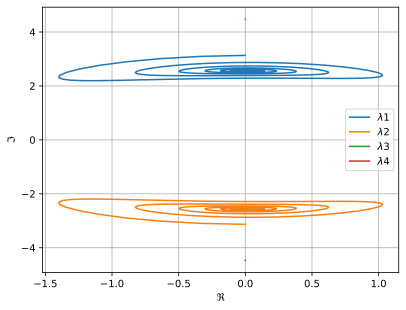

In [29]:
params = set_params(omega_0 = 0, theta_0 = 1, delta_t=0.035, v_0 = 0, x_0 = 0, 
                    n_step=3000,k=20,l=1,m=1)


plot_eigenval('BE',params)

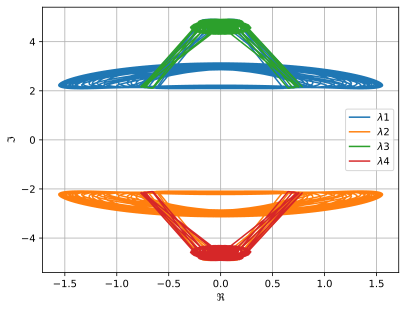

In [30]:
plot_eigenval('CN',params)

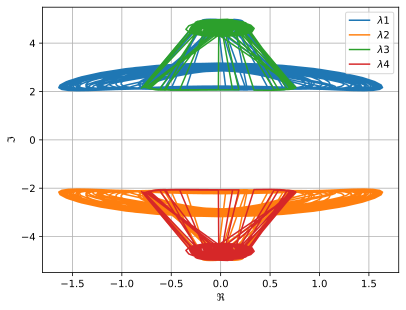

In [31]:
plot_eigenval('AM',params)

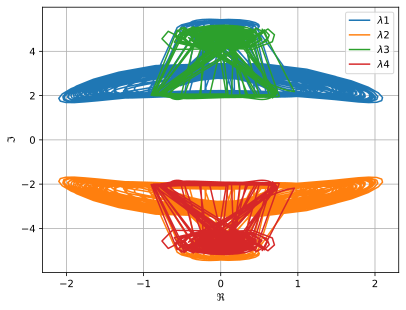

In [32]:
plot_eigenval('BDF',params)

**Result**

From the above plots, at $\Delta t =0.035$ we can see that BDF and Adams-Moulton show strong oscillatory behavior with those big imaginary numbers. Also, from the interactive graph, we can see that both BDF and Adams-Moulton are not stable when $\Delta t > 0.035$. So with this particular problem, time step still needs to be very small even for implicit methods such as Adams-Moulton and BDF.

### 3.5 Testing Hypothesis 4: A small initial angular displacement can result in big angular displacement

In [36]:
def getCoords(L,theta):
    x = L*np.sin(theta)
    y = -L*np.cos(theta)
    return x,y

In [48]:
l = 1
params = set_params(omega_0 = 0, theta_0 = 1, delta_t=0.01, v_0 = 0, x_0 = 0, 
                    n_step=3000,k=20,l=1,m=1)
x = CN(params, rhsFunc).x_
theta = CN(params, rhsFunc).theta_
time  = CN(params, rhsFunc).time_
L = x+l
x_coord, y_coord = getCoords(L,theta)

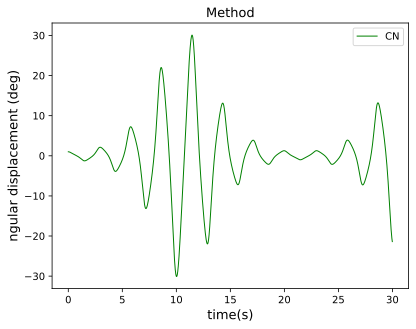

In [50]:
plt.plot(time,theta*180/np.pi,lw=1,color='green', label='CN')
plt.xlabel('time(s)',size=13)
plt.ylabel('ngular displacement (deg)',size=13)
plt.legend()
plt.title('Method',size=13)
plt.show()
        

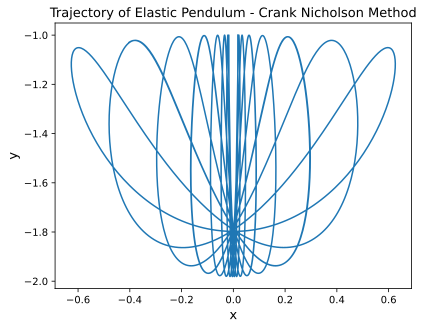

In [41]:
plt.plot(x_coord, y_coord,)
plt.xlabel('x',size=13)
plt.ylabel('y',size=13)
plt.title('Trajectory of Elastic Pendulum - Crank Nicholson Method',size=13)
# plt.savefig('CN.svg')
plt.show()

3000


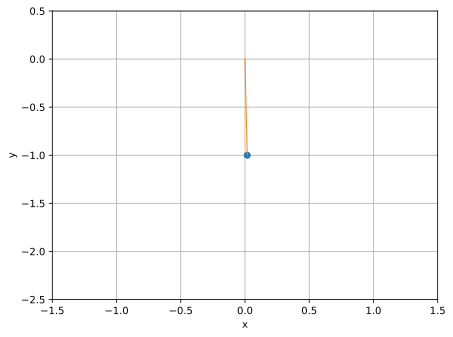

In [47]:
def animate_it(x,y):
    t = np.arange(0,300,0.1)
#     print(np.size(t))
    fig, ax = plt.subplots()
    ax.set_xlim((-1.5,1.5))
    ax.set_ylim((-2.5,0.5))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    plt.tight_layout()
    
    lines = [ax.plot([], [], 'o-', lw = 5)[0],
             ax.plot([], [], '-', lw = 1)[0]]
    
    
    def animate(i):
        lines[0].set_data([x[i]],[y[i]])
        lines[1].set_data([[0,x[i]]],[[0,y[i]]])
        return lines
    
    itsgrooving = animation.FuncAnimation(fig, animate, frames=(len(t)),
                                         interval=900,
                                         blit=False)
    ffmpeg_writer = animation.FFMpegWriter(fps=30)
    itsgrooving.save('CN.gif', writer=ffmpeg_writer)
    return itsgrooving

itsgrooving = animate_it(x_coord,y_coord)

**Result**

From the $\theta$ vs $t$ plot, the $x$ vs $y$ plot, and the animation above, we can clearly see that with just a 1 degree initial angular displacement, the mass can swing out up to 30 degrees, which is about 30 times the original angle. With this information, we can conclude that for this elastic pendulum, a slight angle to start with can result in a big maximum angle of displacement.

## 4. Conclusions 
To sum up the results,
-  Forward Euler is not suitable for this elastic pendulum problem, but RK4 is suitable.
-  Backward Euler may perform better than Forward Euler in providing a solution, but it does not beat RK4 in solving this elastic pendulum problem.
- The studied implicit methods did not give stable solutions at time step larger than 0.035.
- Starting the pendulum at a slight angle can result in a big maximum angle of displacement.
- Other observations: I was surprised at how good RK4 was in solving this problem. It matched so well with the Crank-Nicholson solution.